In [1]:
from matplotlib import pyplot as plt
import numpy as np
import torch
from torch import nn

In [2]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.block1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=9, padding=4),nn.PReLU())
        self.block2 = ResidualBlock(64)
        self.block3 = ResidualBlock(64)
        self.block4 = ResidualBlock(64)
        self.block5 = ResidualBlock(64)
        self.block6 = ResidualBlock(64)
        self.block7 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1),nn.BatchNorm2d(64))
        self.block8 = UpsampleBLock(64, 5)
        self.block9 = nn.Conv2d(64, 3, kernel_size=9, padding=4)

    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)
        block6 = self.block6(block5)
        block7 = self.block7(block6)
        block8 = self.block8(block1 + block7)
        block9 = self.block9(block8)

        return (torch.tanh(block9) + 1) / 2

In [3]:
class UpsampleBLock(nn.Module):
    def __init__(self, in_channels, up_scale):
        super(UpsampleBLock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(up_scale)
        
        # Rearranges elements in a tensor of shape (∗,C×r^2,H,W) 
        # to a tensor of shape (*, C, H x r, W x r).
        # This is useful for implementing efficient sub-pixel convolution with a stride of 1/r
        
        self.prelu = nn.PReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)
        return x

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.prelu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)

        return x + residual

In [5]:
netG = Generator()
netG = netG.cuda()
netG.load_state_dict(torch.load('epochs/srgan-1/netG_epoch_50.pth'))
netG.eval()

Generator(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): PReLU(num_parameters=1)
  )
  (block2): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=1)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block3): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=1)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block4): ResidualBlock(
    (conv1)

In [6]:
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['figure.dpi'] = 300

In [7]:
field_lr = np.load('data/LoRes/Arrays/FIELD/field_2010.npy')
field_hr = np.load('data/HiRes/Arrays/FIELD/field_2010.npy')
field_interp = np.load('data/Interp/FIELD/field_cubic_2010.npy')

In [8]:
wind_lr = np.sqrt(np.square(field_lr[:,0,:,:]) + np.square(field_lr[:,1,:,:]))
wind_hr = np.sqrt(np.square(field_hr[:,0,:,:]) + np.square(field_hr[:,1,:,:]))
wind_interp = np.sqrt(np.square(field_interp[:,0,:,:]) + np.square(field_interp[:,1,:,:]))

In [9]:
slp_lr = field_lr[:,2,:,:]
slp_hr = field_hr[:,2,:,:]
slp_interp = field_interp[:,2,:,:]

In [10]:
field_lr_tensor = torch.from_numpy(field_lr).cuda()

field_norm = torch.zeros_like(field_lr_tensor)

field_norm[:,0,:,:] = (field_lr_tensor[:,0,:,:]+40)/80
field_norm[:,1,:,:] = (field_lr_tensor[:,1,:,:]+40)/80
field_norm[:,2,:,:] = (field_lr_tensor[:,2,:,:]-940)/120

In [11]:
field_nn_norm = netG(field_norm[1448,:,:,:].unsqueeze(0)).squeeze()

In [12]:
field_nn_norm = field_nn_norm.cpu().detach().numpy()

In [13]:
field_nn = np.zeros_like(field_nn_norm)

In [14]:
field_nn[0,:,:] = 80*field_nn_norm[0,:,:] - 40
field_nn[1,:,:] = 80*field_nn_norm[1,:,:] - 40
field_nn[2,:,:] = 120*field_nn_norm[2,:,:] + 940

In [15]:
wind_nn = np.sqrt(np.square(field_nn[0,:,:]) + np.square(field_nn[1,:,:]))
slp_nn = field_nn[2,:,:]

In [ ]:
print(np.min(wind_lr[0,:,:]))
print(np.max(wind_lr[0,:,:]))

In [ ]:
print(np.min(wind_hr[1448,:,:]))
print(np.max(wind_hr[1448,:,:]))

In [ ]:
print(np.min(wind_interp[1448,:,:]))
print(np.max(wind_interp[1448,:,:]))

In [ ]:
print(np.min(wind_nn))
print(np.max(wind_nn))

In [ ]:
_ = plt.imshow(wind_lr[0,:,:], cmap = 'gray', vmin = 0, vmax = 25, origin ='lower')
_ = plt.colorbar()
_ = plt.axis('off')
_ = plt.savefig("low.png")

In [ ]:
_ = plt.imshow(wind_interp[1448,:,:], cmap = 'gray', vmin = 0, vmax = 25, origin ='lower')
_ = plt.colorbar()
_ = plt.axis('off')
_ = plt.savefig("interp.png")

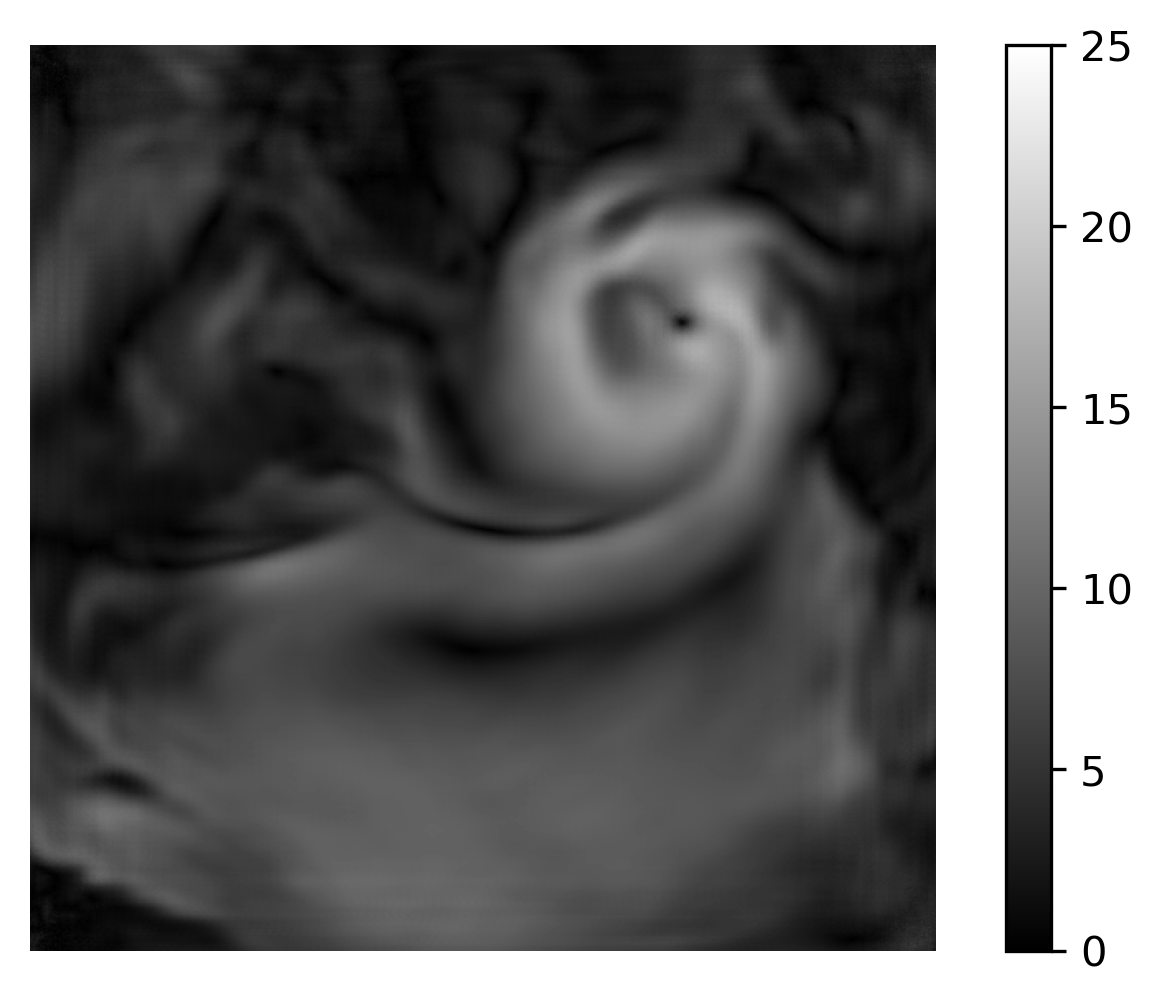

In [16]:
_ = plt.imshow(wind_nn, cmap = 'gray', vmin = 0, vmax = 25, origin ='lower')
_ = plt.colorbar()
_ = plt.axis('off')
_ = plt.savefig("nn-50.png")

In [ ]:
_ = plt.imshow(wind_hr[1448,:,:], cmap = 'gray', vmin = 0, vmax = 25, origin ='lower')
_ = plt.colorbar()
_ = plt.axis('off')
_ = plt.savefig("high.png")

In [ ]:
print(np.min(slp_lr[1448,:,:]))
print(np.max(slp_lr[1448,:,:]))

In [ ]:
print(np.min(slp_hr[1448,:,:]))
print(np.max(slp_hr[1448,:,:]))

In [ ]:
print(np.min(slp_interp[1448,:,:]))
print(np.max(slp_interp[1448,:,:]))

In [ ]:
print(np.min(slp_nn))
print(np.max(slp_nn))

In [ ]:
_ = plt.imshow(slp_lr[1448,:,:], cmap = 'gray', vmin = 975, vmax = 1035, origin ='lower')
_ = plt.colorbar()
_ = plt.axis('off')
_ = plt.savefig("slp-low.png")

In [ ]:
_ = plt.imshow(slp_interp[1448,:,:], cmap = 'gray', vmin = 975, vmax = 1035, origin ='lower')
_ = plt.colorbar()
_ = plt.axis('off')
_ = plt.savefig("slp-interp.png")

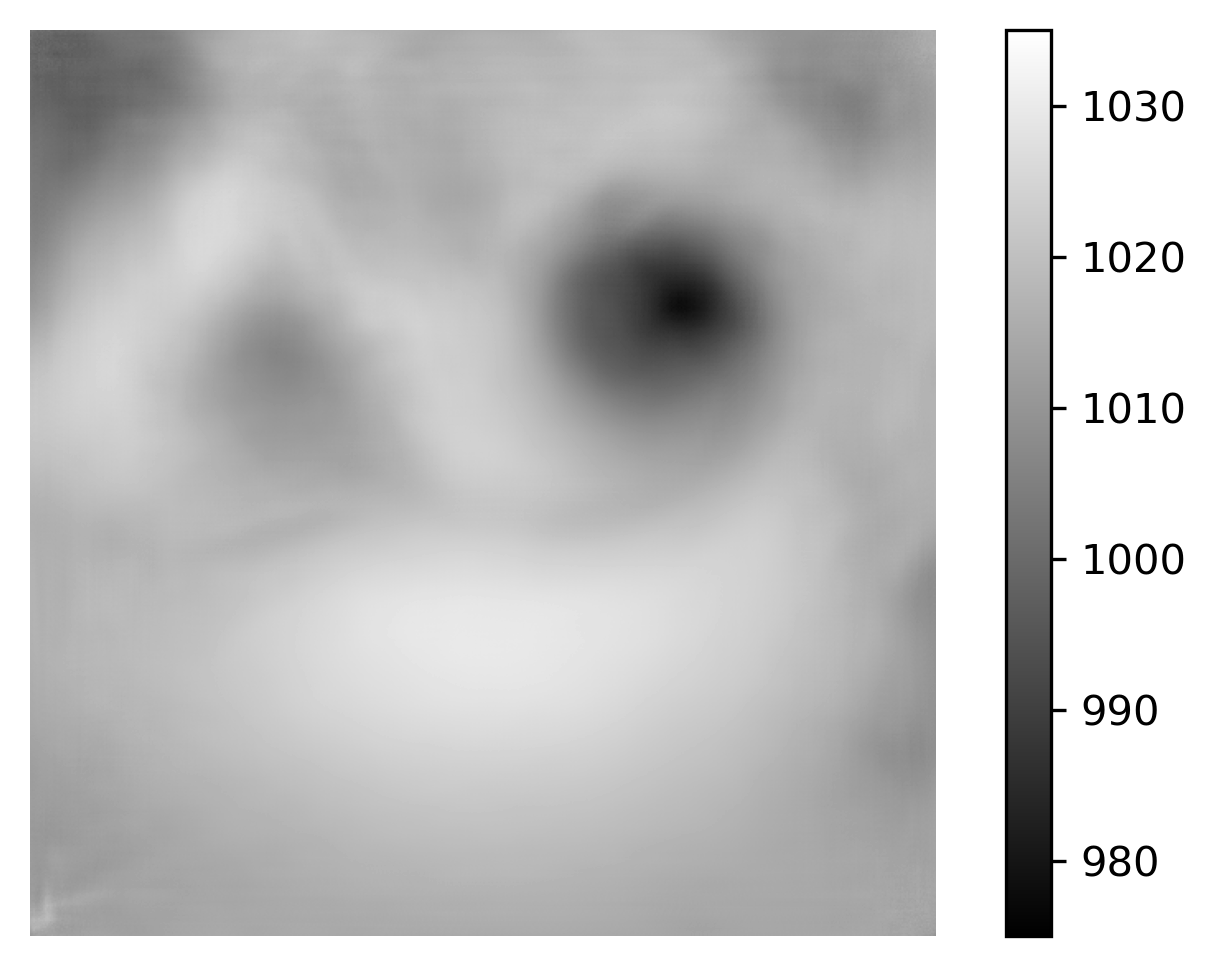

In [17]:
_ = plt.imshow(slp_nn, cmap = 'gray', vmin = 975, vmax = 1035, origin ='lower')
_ = plt.colorbar()
_ = plt.axis('off')
_ = plt.savefig("slp-nn-50.png")

In [ ]:
_ = plt.imshow(slp_hr[1448,:,:], cmap = 'gray', vmin = 975, vmax = 1035, origin ='lower')
_ = plt.colorbar()
_ = plt.axis('off')
_ = plt.savefig("slp-high.png")